# Partie 4 : Génération d'Images

### Importation des libraries et des fichiers

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model

2023-12-18 21:59:31.193691: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 21:59:31.193712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 21:59:31.193718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 21:59:31.198060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Définition des paramètres
file_dir = "./data/"
T = 4.00

In [3]:
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

### Concatenation des données et Creation des Labels

In [4]:
data_all = read_t(T, file_dir, False)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T={T:.02f}.pkl','rb'))
data_all.shape
data_label = np.array([T]*len(data_all))

In [5]:
mean_val = data_all.reshape(data_all.shape[0], 40*40).mean(axis=1)
data_all = data_all.astype(np.uint8)

data_all[mean_val > 0.5] = np.invert(data_all[mean_val > 0.5])//255
data_all.shape

(10000, 1600)

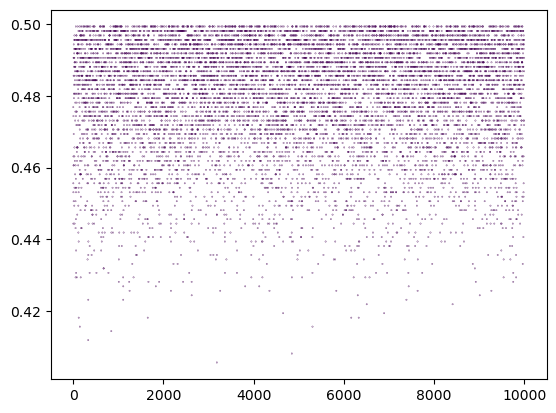

In [6]:
plt.scatter(range(data_all.shape[0]), data_all.reshape(data_all.shape[0], 40*40).mean(axis=1), s=0.05,c =data_label)

In [7]:
tot_data_cnn = data_all.reshape(data_all.shape[0], 1600)

tot_data_cnn = tot_data_cnn.reshape(data_all.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(
    tot_data_cnn, data_label, test_size=0.2, random_state=42)

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-18 21:59:32.599638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 21:59:32.623506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 21:59:32.623911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Modèle Auto-Encoder

In [9]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([

            layers.Input(shape=(40, 40, 1)),
            layers.Conv2D(5, (7, 7), activation='relu', padding='same'),
            layers.Conv2D(5, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(5, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(1, (5, 5), activation='relu', padding='same'),

        ])

        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(5, 5, 1)),
            layers.UpSampling2D((2, 2), interpolation='nearest'),
            layers.Conv2D(5, (5, 5), padding='same', activation='relu'),
            layers.UpSampling2D((2, 2), interpolation='nearest'),
            layers.Conv2D(3, (3, 3), padding='same', activation='relu'),
            layers.UpSampling2D((2, 2), interpolation='nearest'),
            layers.Conv2D(3, (5, 5), padding='same', activation='relu'),
            layers.Conv2D(1, (3, 3), padding='same', activation='relu'),

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder()


# Compile the model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

2023-12-18 21:59:32.636199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 21:59:32.636417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 21:59:32.636611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=264,
                  validation_split=0.2)

Epoch 1/100


2023-12-18 21:59:33.821239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-18 21:59:35.399267: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fad58e280b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 21:59:35.399285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-12-18 21:59:35.402502: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 21:59:35.465824: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 5s 43ms/step - loss: 2.7836 - val_loss: 2.3359
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 2.2763 - val_loss: 2.2249
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 2.1888 - val_loss: 2.1520
Epoch 4/100
25/25 [==============================] - 0s 12ms/step - loss: 2.1213 - val_loss: 2.0896
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 2.0626 - val_loss: 2.0347
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 2.0108 - val_loss: 1.9861
Epoch 7/100
25/25 [==============================] - 0s 12ms/step - loss: 1.9647 - val_loss: 1.9428
Epoch 8/100
25/25 [==============================] - 0s 12ms/step - loss: 1.9235 - val_loss: 1.9037
Epoch 9/100
25/25 [==============================] - 0s 12ms/step - loss: 1.8862 - val_loss: 1.8683
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 1.8522 - val_loss: 1.8358
Epoch 11/10

In [11]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

2023-12-18 22:00:07.161654: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 614.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 22:00:07.379851: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 565.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 22:00:07.393440: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 290.66MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 22:00:07.470766: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

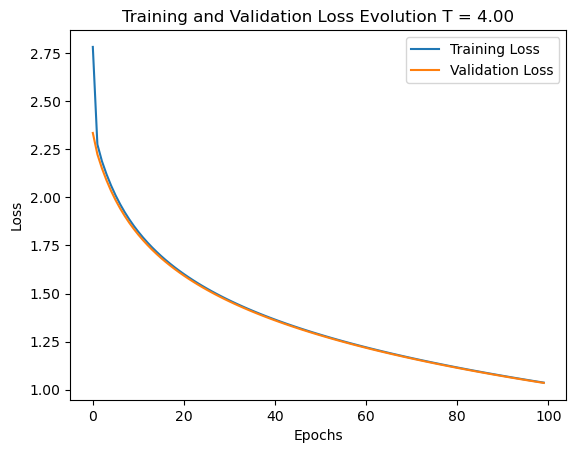

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training and Validation Loss Evolution T = {T:.2f}')
plt.show()

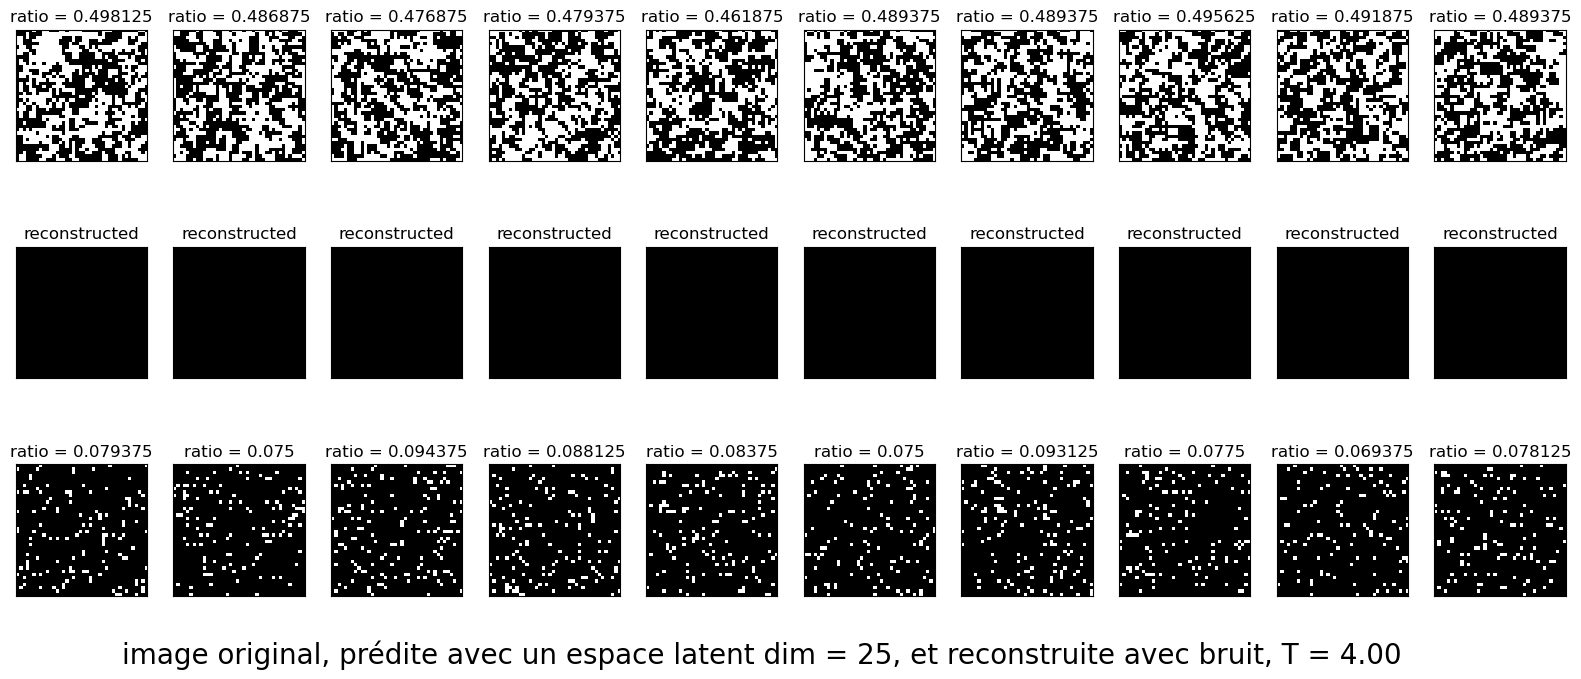

In [13]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    img = np.copy(decoded_imgs[i])
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("ratio = {}".format(np.sum(X_test[i].reshape(1600))/1600))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    img= 2*np.random.normal(0.2,0.15,1600) + 1.5*img.reshape(1600) + 6*np.random.normal(-0.1,0.02,1600)
    img[img<=0.45]=0
    img[img>0.45]=1
    img = img.reshape(40,40)
    plt.imshow(img)
    plt.title("ratio = {}".format(np.sum(img.reshape(1600))/1600))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.text(-400,60,f'image original, prédite avec un espace latent dim = 25, et reconstruite avec bruit, T = {T:.2f}',size = 20)
plt.show()

In [14]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 5)         250       
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 5)         230       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 5)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 5)         230       
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 15)        690       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 15)        0         
 g2D)                                                   

In [15]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 10, 10, 1)         0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 5)         130       
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 20, 20, 5)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 3)         138       
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 40, 40, 3)         0         
 g2D)                                                            
                                                      

In [16]:
encoded_imgs1 = autoencoder.encoder(X_train).numpy()
encoded_imgs1.shape

2023-12-18 22:00:08.458105: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 260.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 22:00:08.458124: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-12-18 22:00:08.555017: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 22:00:08.766675: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out o

ResourceExhaustedError: Exception encountered when calling layer 'conv2d_1' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[8000,5,40,40] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D] name: 

Call arguments received by layer 'conv2d_1' (type Conv2D):
  • inputs=tf.Tensor(shape=(8000, 40, 40, 5), dtype=float32)

In [ ]:
vec1 = np.sum(encoded_imgs1.reshape(np.shape(encoded_imgs1)[0],25),axis=0)
plt.plot(range(25),vec1/np.sum(vec1),label='X_train')
plt.plot(range(25),vec/np.sum(vec),label='X_test')
plt.xlabel('composante nbr')
plt.ylabel('amplitude')
plt.legend()
plt.title(f'vecteur moyen des données T = {T:.2f} dans le sous espace latent')
plt.show()

NameError: name 'encoded_imgs1' is not defined